In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'playground-series-s3e25'
path = setup_comp(comp, install='')

In [3]:
path

Path('playground-series-s3e25')

In [4]:
trn_path = path/'train.csv'

In [5]:
import pandas as pd
df = pd.read_csv(trn_path)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [7]:
df.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


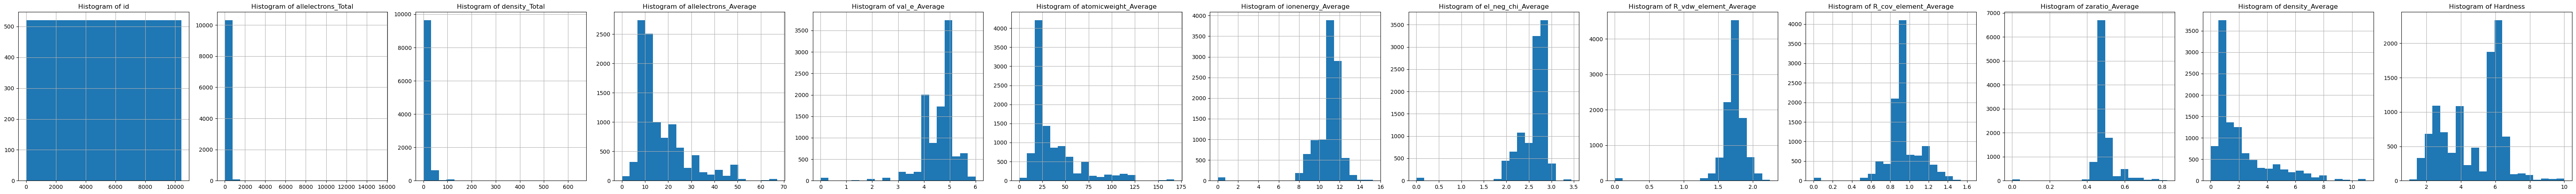

In [8]:
import matplotlib.pyplot as plt

n_rows = 1
n_cols = df.shape[1]

plt.figure(figsize=(5 * n_cols, 5 * n_rows))

for i, column in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    df[column].hist(bins=20)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import loguniform

In [10]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]
X_tr, X_dev, y_tr, y_dev = train_test_split(X,y,test_size=0.2) # XXyy

In [11]:
X_tr.shape, y_tr.shape, X_dev.shape, y_dev.shape

((8325, 11), (8325,), (2082, 11), (2082,))

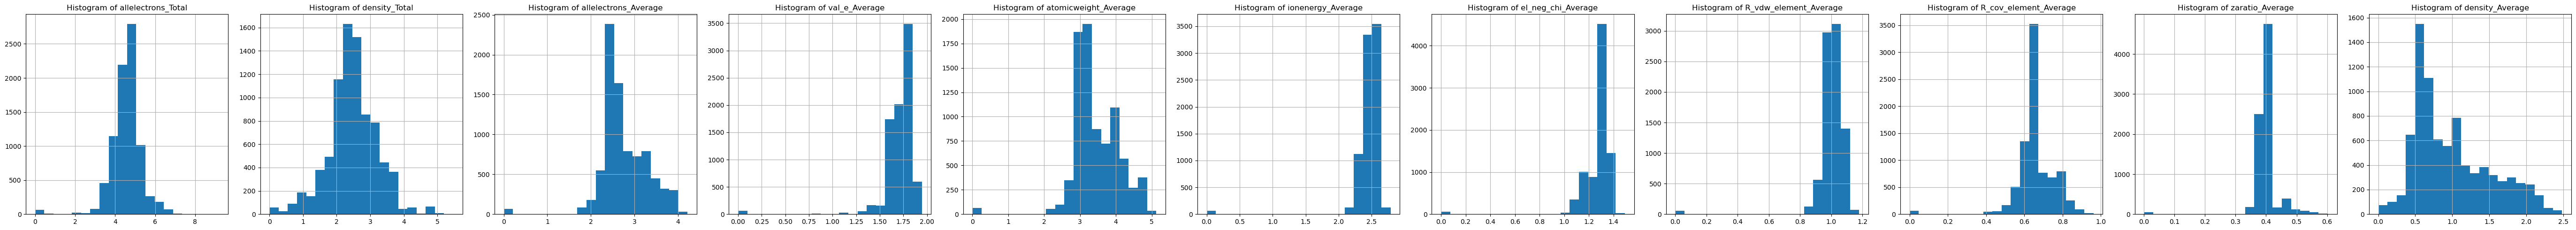

In [12]:
def show_hist_tf(X_tr):
    df = FunctionTransformer(lambda o: np.log(1+o)).fit_transform(X_tr)
    n_rows = 1
    n_cols = df.shape[1]
    
    plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    
    for i, column in enumerate(df.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        df[column].hist(bins=20)
        plt.title(f'Histogram of {column}')
    
    plt.tight_layout()
    plt.show()

show_hist_tf(X_tr)

(array([134., 438., 240., 122., 411., 617.,  65.,  28.,  11.,  16.]),
 array([ 1.3 ,  2.17,  3.04,  3.91,  4.78,  5.65,  6.52,  7.39,  8.26,
         9.13, 10.  ]),
 <BarContainer object of 10 artists>)

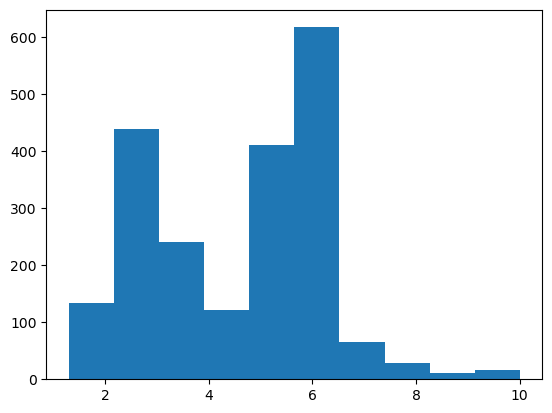

In [13]:
plt.hist(y_dev)

In [14]:
tfs = [FunctionTransformer(lambda o: np.log(1+o)), StandardScaler(), RobustScaler(), MinMaxScaler()]
# model = HistGradientBoostingRegressor(loss='quantile', quantile=0.001)

for scaler in tfs:
    model = HistGradientBoostingRegressor(loss='absolute_error')
    pipe = make_pipeline(scaler, model)
    pipe.fit(X_tr,y_tr)
    y_pred =  pipe.predict(X_dev)
    print(np.abs(y_pred-y_dev).median())

0.5445307735305032
0.5383586201041681
0.5383586201041681
0.5380844888631457


(array([ 19., 203., 181., 154., 219., 176., 228., 837.,  57.,   8.]),
 array([1.50039304, 2.07174214, 2.64309125, 3.21444036, 3.78578947,
        4.35713857, 4.92848768, 5.49983679, 6.07118589, 6.642535  ,
        7.21388411]),
 <BarContainer object of 10 artists>)

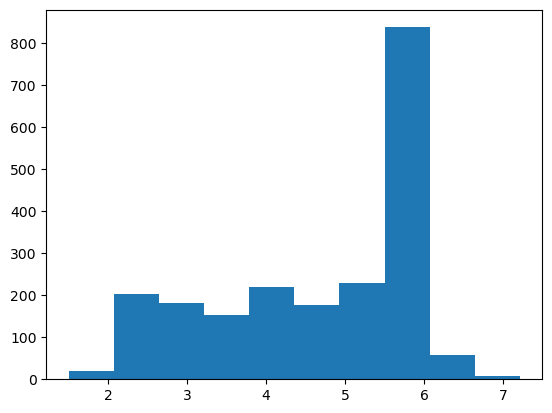

In [15]:
plt.hist(y_pred)

## Submitting to Kaggle

In [16]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,id,Hardness
0,10407,4.647
1,10408,4.647
2,10409,4.647
3,10410,4.647
4,10411,4.647
...,...,...
6934,17341,4.647
6935,17342,4.647
6936,17343,4.647
6937,17344,4.647


In [17]:
tst = pd.read_csv(path/'test.csv')
tst.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [19]:
tst_pred = pipe.predict(tst.iloc[:,1:])

In [21]:
ss['Hardness'] = tst_pred

In [22]:
ss

,id,Hardness
0,10407,2.558294
1,10408,2.533766
2,10409,5.941701
3,10410,4.029536
4,10411,5.476020
...,...,...
6934,17341,5.862255
6935,17342,4.002230
6936,17343,5.568377
6937,17344,4.246037


In [23]:
ss.to_csv('subm.csv', index=False)
!head subm.csv

id,Hardness
10407,2.5582936455607266
10408,2.533766289338745
10409,5.941701360683167
10410,4.029536023653465
10411,5.4760196629992866
10412,5.0768869447141185
10413,3.5923091884562455
10414,5.688913962997869
10415,2.387097976782459


In [24]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial log tf HistGBR', comp)

100%|██████████████████████████████████████████████████████| 164k/164k [00:00<00:00, 200kB/s]


## Conclusion

## Addendum

In [26]:
if not iskaggle:
    push_notebook('xy', 'histgbr-minmax-transform',
                  title='Minmax transform and HistGBR model',
                  file='01-histgbr-minmax-transform.ipynb',
                  competition=comp, private=False, gpu=False)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/xiaochuanyang/minmax-transform-and-histgbr-model
